# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data from https://www.openml.org/d/554 or from default local location `~/scikit_learn_data/...`
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print ('data shape: ', X.shape) # print data shape in Pyhton3
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

train_data shape: (60000, 784) 
 train_labels shape: (60000,) 
 train_labels data type: <class 'str'>


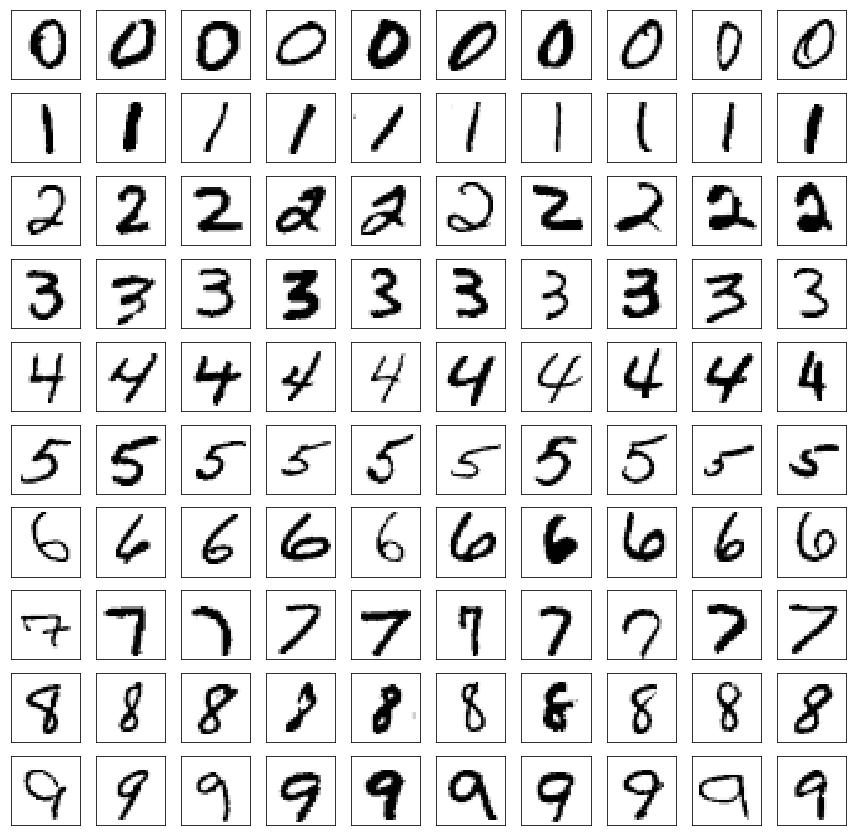

In [3]:
def P1(num_examples=10):
    print("train_data shape:", train_data.shape,"\n", "train_labels shape:", train_labels.shape,"\n", "train_labels data type:", type(train_labels[0])) # printing shape and type of the train_data and train_labels
    fig=plt.figure(figsize=(15, 15)) # setting the size of the plots
    for i in range(10): # for creating 10 rows for 10 digits 
        for j in range(num_examples): # for creating num_examples of columns for the grid
            plt.subplot(10,num_examples,(num_examples*i+j)+1) # for plotting each digit seperately
            digit = np.reshape(train_data[train_labels == str(i)][j], (28,28)) # reshaping 1-D training data to 2-D matrix            
            plt.imshow(digit, cmap='Greys',  interpolation='nearest') # rendering the pixels into grayscale image
            plt.xticks([]) # removing xticks
            plt.yticks([]) # removing yticks
    plt.show() # plotting the figure 
            
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):

### STUDENT START ###
    predictions = [] # creating an empty list to capture each k's predictions  
    for k in k_values: # iterating over each 'k'
      clf = KNeighborsClassifier(n_neighbors=k) # assigning KNeighborsClassifier class to clf variable
      clf.fit(mini_train_data, mini_train_labels) # fitting the mini_train_data and mini_train_labels to the classifier
      predict = clf.predict(dev_data) # predicted labels with each k for KNeighborsClassifier
      predictions.append(predict) # appenidng each k's prediction into predictions list
      print("For k = " + str(k) + ", accuracy on dev data: " + str(clf.score(dev_data, dev_labels)))    
    print(classification_report(dev_labels, predictions[0], target_names=sorted(np.unique(Y)))) # classification report for k=1
    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

For k = 1, accuracy on dev data: 0.884
For k = 3, accuracy on dev data: 0.876
For k = 5, accuracy on dev data: 0.882
For k = 7, accuracy on dev data: 0.877
For k = 9, accuracy on dev data: 0.875
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



ANSWER: Most difficult digit to predict according above f1-score is '8'.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):

### STUDENT START ###    
    for size in train_sizes:  # iterating through each training size
        initial_time = time.time() # initializing time for each size
        clf = KNeighborsClassifier(n_neighbors=1) # assigning KNeighborsClassifier class to clf variable
        clf.fit(train_data[:size], train_labels[:size]) # fitting the train_data and train_labels of size in train_sizes      
        accuracy = clf.score(dev_data, dev_labels) # assigning accuracy of the dev set to the variable
        accuracies.append(accuracy)
        print("For training size " + str(size) +", accuracy on the dev set = " + str(accuracy) + "; time taken for the prediction: " + str(time.time()-initial_time))
     
    return train_sizes, accuracies

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

For training size 100, accuracy on the dev set = 0.702; time taken for the prediction: 0.45081400871276855
For training size 200, accuracy on the dev set = 0.791; time taken for the prediction: 0.8726437091827393
For training size 400, accuracy on the dev set = 0.811; time taken for the prediction: 1.8262519836425781
For training size 800, accuracy on the dev set = 0.866; time taken for the prediction: 3.7413148880004883
For training size 1600, accuracy on the dev set = 0.905; time taken for the prediction: 7.681223630905151
For training size 3200, accuracy on the dev set = 0.927; time taken for the prediction: 15.741514921188354
For training size 6400, accuracy on the dev set = 0.939; time taken for the prediction: 27.512897968292236
For training size 12800, accuracy on the dev set = 0.952; time taken for the prediction: 70.57807493209839
For training size 25000, accuracy on the dev set = 0.962; time taken for the prediction: 140.37189936637878


([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000],
 [0.702, 0.791, 0.811, 0.866, 0.905, 0.927, 0.939, 0.952, 0.962])

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

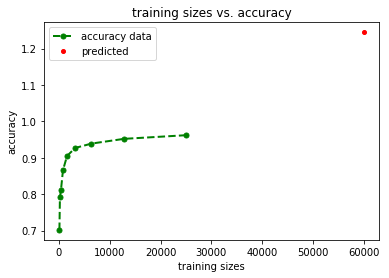

Predicted accuracy for train size(n) of 60000: 1.245


In [6]:
def P4():
    
### STUDENT START ###
    train_sizes_vector, accuracies_vector  = np.array(train_sizes), np.array(accuracies) # converting lists into numpy arrays
    train_sizes_matrix = train_sizes_vector.reshape(train_sizes_vector.shape[0],1) # converting train_sizes_vector into a matrix
    lr = LinearRegression() # assigning LineareRegression to 'lr' variable    
    lr.fit(train_sizes_matrix, accuracies_vector) # fitting training_sizes_matrix and accuracies_vector to LinearRegression
    predict = lr.predict([[60000]]) # predicting the accuracy for train_size = 60,000
    plt.plot(np.array(train_sizes), np.array(accuracies), 'go--', linewidth=2, markersize=5, label="accuracy data") # plotting the train_sizes and accuracies  
    plt.plot(np.array([60000]), np.array([predict]), 'ro', markersize=4, label="predicted") # plotting the predicted value for train size = 60,000
    plt.xlabel("training sizes") # xlabel of the plot 
    plt.ylabel("accuracy") # ylabel of the plot
    plt.title("training sizes vs. accuracy") # title of the plot
    plt.legend() # legend of the plot
    plt.show() # plotting the figure
    print("Predicted accuracy for train size(n) of 60000:", round(predict[0], 3))

### STUDENT END ###

P4()

ANSWER: As accuracy can not be more than 1.0, the predicted accuracy, 1.245, is not reasonable prediction in this case. So, we can do a transformation (power by 60) on accuracies to linearize the plot and prediction.

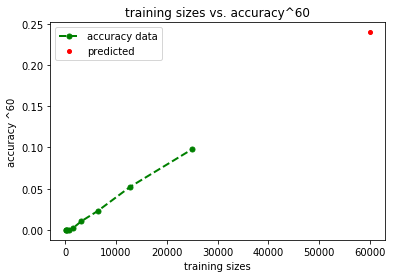

Predicted accuracy for train size(n) of 60000: 0.9765


In [7]:
    
    train_sizes_vector, accuracies_vector  = np.array(train_sizes), np.array(accuracies) # converting lists into numpy arrays
    train_sizes_matrix = train_sizes_vector.reshape(train_sizes_vector.shape[0],1) # converting train_sizes_vector into a matrix    
    lr2 = LinearRegression() # assigning LineareRegression to 'lr' variable    
    lr2.fit(train_sizes_matrix, np.power(accuracies_vector, 60)) # fitting training_sizes_matrix and power transformed accuracies_vector to LinearRegression
    predict = lr2.predict([[60000]]) # predicting the accuracy for train_size = 60,000
    plt.plot(np.array(train_sizes), np.array(accuracies)**60, 'go--', linewidth=2, markersize=5, label="accuracy data") # plotting the train_sizes and poer transformed accuracies  
    plt.plot(np.array([60000]), np.array([predict]), 'ro', markersize=4, label="predicted") # plotting the predicted value for train size = 60,000
    plt.xlabel("training sizes") # xlabel of the plot 
    plt.ylabel("accuracy ^60") # ylabel of the plot
    plt.title("training sizes vs. accuracy^60") # title of the plot
    plt.legend() # legend of the plot
    plt.show() # plotting the figure
    plt.show() # plotting the figure
    print("Predicted accuracy for train size(n) of 60000:", round(np.power(predict[0], 1/60), 4))


Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[105   1   0   0   0   0   0   0   0   0]
 [  0 117   0   0   0   0   0   0   1   0]
 [  1   0 102   0   0   0   0   2   1   0]
 [  0   1   0  92   0   2   0   1   1   0]
 [  0   0   0   0  92   0   0   0   0   0]
 [  1   0   0   2   0  83   1   0   0   1]
 [  0   0   0   0   0   1 100   0   1   0]
 [  0   0   1   0   0   0   0 101   0   0]
 [  1   1   2   2   1   0   2   0  85   0]
 [  0   0   0   0   1   0   0   0   0  94]]
Accuracy on dev data:  0.971
Most confused pair of digits are 8 and 6. We see that digit 8 is mislabeled 9 times. Let us plot them to see how they look


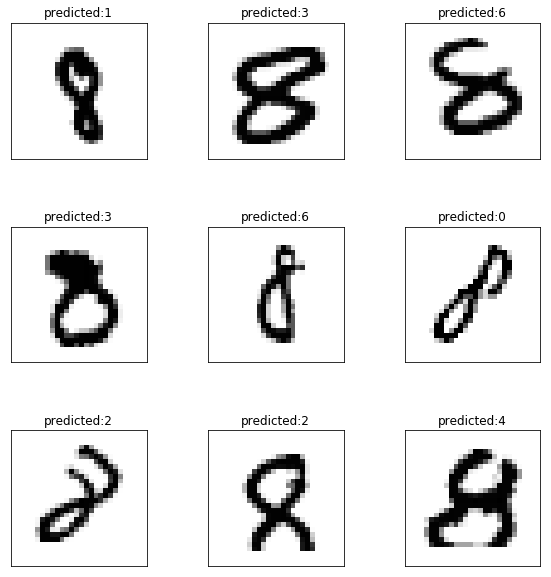

In [8]:
def P5():

### STUDENT START ###
     clf = KNeighborsClassifier(n_neighbors=1) # assigning KNeighborsClassifier class to clf variable
     clf.fit(train_data, train_labels) # fitting the train_data and train_labels 
     predict = clf.predict(dev_data) # predicted labels for dev data    
     print(confusion_matrix(dev_labels, predict, labels = sorted(np.unique(Y)))) # printing confusion matrix 
     print("Accuracy on dev data: ", clf.score(dev_data, dev_labels) )   
     print("Most confused pair of digits are 8 and 6. We see that digit 8 is mislabeled 9 times. Let us plot them to see how they look")
     mislabel_digit_index = (dev_labels == str(8)) & (predict != str(8)) # Creating a boolean array where digit 8 is mislabeled
     mislabel_digit = predict[mislabel_digit_index] # mislabeled digits for digit 8
     fig=plt.figure(figsize=(10,10))
     for i in range(9): # iterating through 9 times for 9 mislabeld digits
        plt.subplot(3,3,i+1) # sub-plotting each mislabeled digit(8)
        digit = np.reshape(dev_data[mislabel_digit_index][i], (28,28)) # rehaping the mislabeled digit array into a matrix for displaying the image
        plt.imshow(digit, cmap='Greys',  interpolation='nearest')        
        plt.title("predicted:" + (predict[mislabel_digit_index][i]))
        plt.xticks([]) # removing xticks
        plt.yticks([]) # removing yticks
        plt.subplots_adjust(hspace = 0.5) # to provide height space between subplots
     plt.show()   
               
        
                                 
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

Accuracy on the dev data for preprocessed training data:  0.971
Accuracy on the preprocessed dev data for training data:  0.969
Accuracy on the preprocessed dev data for preprocessed training data:  0.968


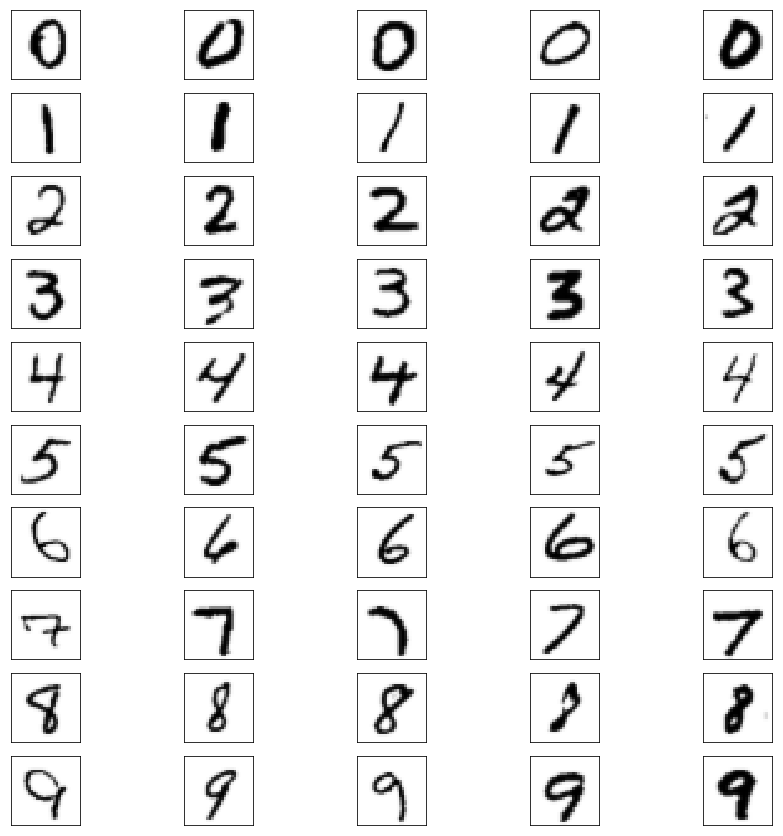

In [9]:
def P6():
    
### STUDENT START ###
    from scipy.ndimage.filters import gaussian_filter
    sigma = 0.5 # sigma for Guassian filter
    # 1. preprocess the training data but not the dev data
    clf = KNeighborsClassifier(n_neighbors=1) # assigning KNeighborsClassifier class to clf variable
    clf.fit(gaussian_filter(train_data, sigma), train_labels) # fitting the gaussian filtered train_data and train_labels 
    accuracy1 = clf.score(dev_data, dev_labels) # assigning accuracy of the dev set to the variable
    print("Accuracy on the dev data for preprocessed training data: ", accuracy1) 
    
    # 2. preprocess the dev data but not the training data
    clf = KNeighborsClassifier(n_neighbors=1) # assigning KNeighborsClassifier class to clf variable
    clf.fit(train_data, train_labels) # fitting the train_data and train_labels 
    accuracy2 = clf.score(gaussian_filter(dev_data, sigma), dev_labels) # assigning accuracy of the gaussian filtered dev set to the variable
    print("Accuracy on the preprocessed dev data for training data: ", accuracy2) 
    
    # 3. preprocess both training and dev data
    clf = KNeighborsClassifier(n_neighbors=1) # assigning KNeighborsClassifier class to clf variable
    clf.fit(gaussian_filter(train_data, sigma), train_labels) # fitting the gaussian filtered train_data and train_labels 
    accuracy3 = clf.score(gaussian_filter(dev_data, sigma), dev_labels) # assigning accuracy of the gaussian filtered dev set to the variable
    print("Accuracy on the preprocessed dev data for preprocessed training data: ", accuracy3)
    
    num_examples = 5 # number of examples for plotting the guassian filtered digits
    fig=plt.figure(figsize=(15, 15)) # setting the size of the plots
    for i in range(10): # for creating 10 rows for 10 digits 
        for j in range(num_examples): # for creating num_examples of columns for the grid
            plt.subplot(10,num_examples,(num_examples*i+j)+1) # for plotting each digit seperately
            digit = np.reshape(train_data[train_labels == str(i)][j], (28,28)) # reshaping 1-D training data to 2-D matrix            
            plt.imshow(gaussian_filter(digit, sigma), cmap='Greys',  interpolation='nearest') # rendering the gaussian pixels into grayscale image
            plt.xticks([]) # removing xticks
            plt.yticks([]) # removing yticks
    plt.show() # plotting the figure 


### STUDENT END ###

P6()

ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [10]:
def P7():

### STUDENT START ###
    def preprocess_wgb(matrix_original):  # function to convert pixel values to white(0), grey(1), black(2)
        matrix = matrix_original.copy() # copying the matrix_original into a new matrix
        for i in range(matrix.shape[0]): # iterating through the number of rows in the matrix
            matrix[i] [matrix[i] < 0.33 ] = 0 # checking if the pixel value is less than 0.33 and assigning value '0'
            matrix[i] [(0.33 < matrix[i]) & (matrix[i] < 0.66)] = 1 # checking if the pixel value is less than 0.66 and greater than 0.33 and assigning value '1'
            matrix[i] [matrix[i] > 0.66 ] = 2 # checking if the pixel value is greater than 0.66 and assigning value '2'
        return matrix  # returning the transformed matrix that consists of pixels with values: 0, 1, 2
        
    BernoulliNB_clf = BernoulliNB(binarize=0.2) # assigning BernoulliNB (binarize threshold = 0.2) Class to a variable
    BernoulliNB_clf.fit(train_data, train_labels) # fitting the train_data and train_labels to the classifier
    BernoulliNB_clf_accuracy = BernoulliNB_clf.score(dev_data, dev_labels) # calculating the accuracy of the classifier on dev_data
    print("Accuracy on dev set using BernoulliNB:", BernoulliNB_clf_accuracy)
    MultinomialNB_clf = MultinomialNB() #assigning MultinomialNB Class to a variable
    MultinomialNB_clf.fit(train_data, train_labels) # fitting the train_data and train_labels to the classifier
    MultinomialNB_clf_accuracy = MultinomialNB_clf.score(dev_data, dev_labels)  # calculating the accuracy of the classifier on dev_data
    print("Accuracy on dev set using MultinomialNB without preprocessing:", MultinomialNB_clf_accuracy)
    MultinomialNB_wgb_clf = MultinomialNB() #assigning MultinomialNB Class to a variable
    MultinomialNB_wgb_clf.fit(preprocess_wgb(train_data), train_labels) # fitting the preprocessed train_data and train_labels to the classifier
    MultinomialNB_wgb_clf_accuracy = MultinomialNB_wgb_clf.score(preprocess_wgb(dev_data), dev_labels) # calculating the accuracy of the classifier on preprocessed dev_data
    print("Accuracy on dev set using MultinomialNB with preprocessing to white, grey and black (0,1,2):", MultinomialNB_wgb_clf_accuracy)
    


    
### STUDENT END ###

P7()

Accuracy on dev set using BernoulliNB: 0.83
Accuracy on dev set using MultinomialNB without preprocessing: 0.822
Accuracy on dev set using MultinomialNB with preprocessing to white, grey and black (0,1,2): 0.823


ANSWER: Multinomial Naive Bayes Classifier did not perform well compared to Bernoulli Classifier. As the MultinomialNB classifier looks for the frequency of pixel values, which may not always be the same (even for the same digit).However, the score is improved by classifing the pixel values into 3 discrete (0,1,2) values rather than a continued values in range [0,1]. 

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [11]:
def P8(alphas):

### STUDENT START ###    
    clf_alpha0 = BernoulliNB(binarize=0.2, alpha = 0.0) # assigning BernoulliNB Class (with binarize=0.2, alpha = 0.0) to a variable
    clf_alpha0.fit(train_data, train_labels) # fitting the train_data and train_labels
    accuracy = clf_alpha0.score(dev_data, dev_labels) # calculating the accuracy of the classifier
    print("Accuracy of the classifier when alpha is 0.0: ", accuracy)
    BernoulliNB_clf =  BernoulliNB(binarize=0.2) # assigning BernoulliNB Class (with binarize=0.2) to a variable
    clf_search = GridSearchCV(BernoulliNB_clf, alphas) # assiging the GridSearchCV Class (with alpha values)
    return clf_search.fit(train_data, train_labels) # fitting the tain_data and train_labels


### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

C:\Users\vencxbikkanur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\vencxbikkanur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy of the classifier when alpha is 0.0:  0.831


C:\Users\vencxbikkanur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\vencxbikkanur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\vencxbikkanur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\vencxbikkanur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [12]:
print (nb.best_params_)

{'alpha': 0.0}


ANSWER:

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [13]:
def P9():

### STUDENT END ###
    GuassianNB_clf = GaussianNB()  # assigning GaussianNB Class to a variable
    GuassianNB_clf.fit(train_data, train_labels) # fitting train_data and train_labels to the classifier
    GuassianNB_clf_accuracy = GuassianNB_clf.score(dev_data, dev_labels) # calculating the accuracy of the classifier
    print("Accuracy on dev set using GaussianNB with no variance smoothing: ", GuassianNB_clf_accuracy)
    print("Parameters: ", GuassianNB_clf.get_params) 
    print("theta shape:", GuassianNB_clf.theta_.shape)
    print("maximum theta value for digit 0:", GuassianNB_clf.theta_[0].max())
    print("sigma shape:", GuassianNB_clf.sigma_.shape)
    print("maximum sigma value for digit 0:", GuassianNB_clf.sigma_[0].max(), "\n")
    
     
    # setting var_smoothing = 0.05 to GaussianNB
    GuassianNB_clf = GaussianNB(var_smoothing = 0.05)  # assigning GaussianNB Class with variance smoothing = 0.05 to a variable
    GuassianNB_clf.fit(train_data, train_labels) # fitting train_data and train_labels to the classifier
    GuassianNB_clf_accuracy = GuassianNB_clf.score(dev_data, dev_labels) # calculating the accuracy of the classifier
    print("Accuracy on dev set using GaussianNB with 0.05 variance smoothing:  ", GuassianNB_clf_accuracy)
    print("Parameters: ", GuassianNB_clf.get_params)    
    
   
    

### STUDENT END ###

gnb = P9()

Accuracy on dev set using GaussianNB with no variance smoothing:  0.586
Parameters:  <bound method BaseEstimator.get_params of GaussianNB(priors=None, var_smoothing=1e-09)>
theta shape: (10, 784)
maximum theta value for digit 0: 0.7881771478599949
sigma shape: (10, 784)
maximum sigma value for digit 0: 0.19697148802757583 

Accuracy on dev set using GaussianNB with 0.05 variance smoothing:   0.814
Parameters:  <bound method BaseEstimator.get_params of GaussianNB(priors=None, var_smoothing=0.05)>


ANSWER: Applying a variance smoothing 0.05) to the GaussianNB classifier improved the accuracy on the dev data.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

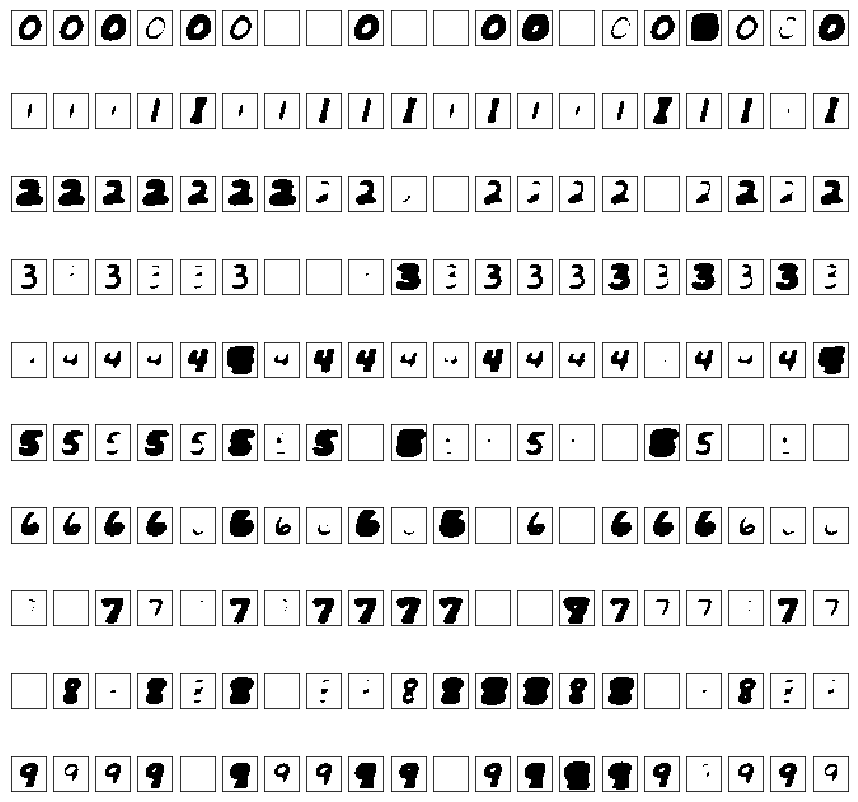

In [14]:
def P10(num_examples):

### STUDENT START ###
    BernoulliNB_clf = BernoulliNB(binarize=0.2) # assigning BernoulliNB Class to a variable
    BernoulliNB_clf.fit(train_data, train_labels) # fitting the train_data and traing_labels to the classifier    
    BernoulliNB_clf_feature_prob =  np.exp(BernoulliNB_clf.feature_log_prob_) # assiging feature proabilities from the classifier to a variable    
    fig=plt.figure(figsize=(15, 15)) # setting the plot size
    for i in range(10): # for creating 10 rows for 10 digits 
        for j in range(num_examples): # for creating num_examples of columns for the grid
            plt.subplot(10,num_examples,(num_examples*i+j)+1) # for plotting each digit seperately
            digit = np.zeros((784,)) # creating a zero array of size 784
            digit[BernoulliNB_clf_feature_prob[i] > np.random.rand()] = 1 # assigning '1' to pixels where the probability is more than a random number           
            plt.imshow(digit.reshape((28,28)), cmap='Greys',  interpolation='nearest') # rendering the pixels into grayscale image
            plt.xticks([]) # removing xticks
            plt.yticks([]) # removing yticks
    plt.show()        

### STUDENT END ###

P10(20)

ANSWER:The generated digits looks an approximation of how a digit is based on the training data. However, based on the random threshold probability (random.rand()) for making a pixel black (1), the digit varied in its appearance.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [15]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    def prob_bin(List, number): # defining a function to select the appropriate (index) bucket for the max probability value
        for e in List: # iterating through each bucket element
            if number <= e: # checking if the max probability is less than or equal to the bucket element
                return List.index(e)   # if true, returning the index of the bucket it belongs to    
    BernoulliNB_clf = BernoulliNB(binarize=0.2, alpha = 0.0) # assigning BernoulliNB Class to a variable
    BernoulliNB_clf.fit(train_data, train_labels) # fitting the train_data and traing_labels to the classifier
    BernoulliNB_clf_predict_digit = BernoulliNB_clf.predict(dev_data) # predicted digit for the dev_data
    BernoulliNB_clf_predict_proba = BernoulliNB_clf.predict_proba(dev_data) # predicted probability for each dev_data
    for index in range(BernoulliNB_clf_predict_proba.shape[0]): # iterating over the number of rows in dev_data
        bin_index = prob_bin(buckets, BernoulliNB_clf_predict_proba[index].max()) # finding the index of the bucket for the max probability
        total[bin_index] += 1  # increaing the count number of the bucket
        if dev_labels[index] == BernoulliNB_clf_predict_digit[index]: correct[bin_index] += 1 # increaing the number for the correct bucket 
    return buckets, correct, total
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
   accuracy = 0.0
   if (total[i] > 0): accuracy = correct[i] / total[i]
   print ('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   1    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  23    accuracy = 0.435
p(pred) <= 0.9990000000000    total =  87    accuracy = 0.506
p(pred) <= 0.9999900000000    total =  53    accuracy = 0.509
p(pred) <= 0.9999999000000    total =  54    accuracy = 0.704
p(pred) <= 0.9999999990000    total =  47    accuracy = 0.660
p(pred) <= 0.9999999999900    total =  82    accuracy = 0.780
p(pred) <= 0.9999999999999    total =  52    accuracy = 0.827
p(pred) <= 1.0000000000000    total = 601    accuracy = 0.955


C:\Users\vencxbikkanur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


ANSWER: From above max probability for the dev_data buckets, we can see that most of the clibrated probabilities are above 0.9 and the acuracy improves as the probability increase.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [19]:
def P12():

### STUDENT START ###
   # Summing the pixel values in each row and each column.
    def add_row_col(data_original):
        data_copy = data_original.copy() # copying the original vector into a new vector 
        data = np.hstack((data_copy, np.zeros((data_original.shape[0], 57)))) # padding extra column and row (29 X 29) for each data        
        for index in range(data.shape[0]): #iterating through each row in the data
            for i in range(28): # iterating for each 28 rows 
                data[index][784+i] = data[index][i*28:28*(i+1)].sum() # adding the sum of each row to the newly created column
            for j in range(28): # iterating for each 28 columns 
                indices = [k for k in range(j, 784, 28)] # indices for column level matrix
                data[index][812+j] = data[index][indices].sum() # adding the sum of each column to the newly created row       
        return data
    train_data_preprocessed =  add_row_col(train_data) # preprocessing the train_data
    dev_data_preprocessed = add_row_col(dev_data)  # preprocessing the dev_data
    BernoulliNB_clf = BernoulliNB(binarize=0.2) # assigning BernoulliNB (binarize threshold = 0.2) Class to a variable
    BernoulliNB_clf.fit(train_data_preprocessed, train_labels) # fitting the preprocessed train_data and train_labels to the classifier
    BernoulliNB_clf_accuracy = BernoulliNB_clf.score(dev_data_preprocessed, dev_labels) # calculating the accuracy of the classifier on preprocessed dev_data
    print("Accuracy on dev set using BernoulliNB:", BernoulliNB_clf_accuracy, ". Accuracy is improved compared to non-preprocessed classifier (0.83) ") 
    
 
        
        

### STUDENT END ###

P12()

Accuracy on dev set using BernoulliNB: 0.837 . Accuracy is improved compared to non-preprocessed classifier (0.83) 
